# Data Loading

In [5]:
from data.WikiText import WikiTextDataset
import tiktoken

# tokenizer = tiktoken.get_encoding("cl100k_base")
tokenizer = tiktoken.get_encoding("gpt2")

In [6]:
wikitext = WikiTextDataset(subset="wikitext-2-raw-v1", split="train", max_length=128, stride=64, tokenizer=tokenizer)

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(wikitext, batch_size=8, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
input_ids, target_ids = batch
print("Input IDs shape:", input_ids.shape)
print("Target IDs shape:", target_ids.shape)

Input IDs shape: torch.Size([8, 128])
Target IDs shape: torch.Size([8, 128])


# Model

In [ ]:
from models.GPT2 import GPTModel

In [ ]:
gpt2_small_cfg = {
    "vocab_size": 50257,
    "max_seq_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.1,
    "qkv_bias": True,
}

In [ ]:
model = GPTModel(gpt2_small_cfg)

# Utilities

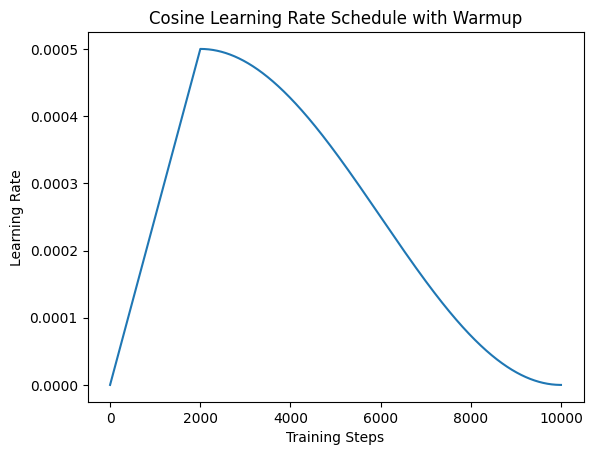

In [ ]:
# Plot learning rate schedule example
import torch
import matplotlib.pyplot as plt
from utils import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=2000, num_training_steps=10000)
lrs = []
for step in range(10000):
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
plt.plot(lrs)
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Cosine Learning Rate Schedule with Warmup")
plt.show()

# Training

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from data.WikiText import WikiTextDataset
from models.GPT2 import GPTModel
from utils import generateText, get_cosine_schedule_with_warmup
import tiktoken
import time
import mlflow
from tqdm import tqdm

gpt2_small_cfg = {
    "vocab_size": 50264,
    "max_seq_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.1,
    "qkv_bias": True,
}

hyperparams = {
    "ds_context_length": 1024,
    "ds_stride": 512,
    "ds_batch_size": 8,
    "peak_learning_rate": 6e-4,
    "weight_decay": 0.1,
    "max_epochs": 10,
    "model_config": gpt2_small_cfg,
    "tokenizer": "gpt2",
    "early_stopping_patience": 2,
    "adam_betas": (0.9, 0.95),
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "logging_interval": 100,
}

tokenizer = tiktoken.get_encoding(hyperparams["tokenizer"])

train_ds = WikiTextDataset(
    subset="wikitext-2-raw-v1",
    split="train",
    max_length=hyperparams["ds_context_length"],
    stride=hyperparams["ds_stride"],
    tokenizer=tokenizer,
)
val_ds = WikiTextDataset(
    subset="wikitext-2-raw-v1",
    split="validation",
    max_length=hyperparams["ds_context_length"],
    stride=hyperparams["ds_stride"],
    tokenizer=tokenizer,
)
# test_ds = WikiTextDataset(subset="wikitext-2-raw-v1", split="test", max_length=hyperparams["ds_context_length"], stride=hyperparams["ds_stride"], tokenizer=tokenizer)

train_dl = DataLoader(
    train_ds,
    batch_size=hyperparams["ds_batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
)
val_dl = DataLoader(val_ds, batch_size=hyperparams["ds_batch_size"], pin_memory=True, num_workers=8)
# test_dl = DataLoader(test_ds, batch_size=hyperparams["ds_batch_size"], pin_memory=True)

model = GPTModel(hyperparams["model_config"])
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=hyperparams["peak_learning_rate"],
    fused=True,
    weight_decay=hyperparams["weight_decay"],
    betas=hyperparams["adam_betas"],
)

In [10]:
for name, param in model.named_parameters():
    if param.requires_grad and "fc" in name and param.grad is not None:
        print(f"Parameter: {name}, Shape: {param.shape}")

Parameter: blocks.0.ffn.fc1.weight, Shape: torch.Size([3072, 768])
Parameter: blocks.0.ffn.fc1.bias, Shape: torch.Size([3072])
Parameter: blocks.0.ffn.fc2.weight, Shape: torch.Size([768, 3072])
Parameter: blocks.0.ffn.fc2.bias, Shape: torch.Size([768])
Parameter: blocks.1.ffn.fc1.weight, Shape: torch.Size([3072, 768])
Parameter: blocks.1.ffn.fc1.bias, Shape: torch.Size([3072])
Parameter: blocks.1.ffn.fc2.weight, Shape: torch.Size([768, 3072])
Parameter: blocks.1.ffn.fc2.bias, Shape: torch.Size([768])
Parameter: blocks.2.ffn.fc1.weight, Shape: torch.Size([3072, 768])
Parameter: blocks.2.ffn.fc1.bias, Shape: torch.Size([3072])
Parameter: blocks.2.ffn.fc2.weight, Shape: torch.Size([768, 3072])
Parameter: blocks.2.ffn.fc2.bias, Shape: torch.Size([768])
Parameter: blocks.3.ffn.fc1.weight, Shape: torch.Size([3072, 768])
Parameter: blocks.3.ffn.fc1.bias, Shape: torch.Size([3072])
Parameter: blocks.3.ffn.fc2.weight, Shape: torch.Size([768, 3072])
Parameter: blocks.3.ffn.fc2.bias, Shape: torch.

In [ ]:
# Log gradients for each linear layer
def log_gradients(model, step):
    for name, param in model.named_parameters():
        if param.requires_grad and "linear" in name and param.grad is not None:
            mlflow.log_metric(f"grad_norm_{name}", param.grad.norm().item(), step=step)

In [2]:
def calculateLossBatch(logits: torch.Tensor, target_ids: torch.Tensor) -> torch.Tensor:
    loss = F.cross_entropy(logits.flatten(0, 1), target_ids.flatten())
    return loss


def validateModelLoader(
    model: nn.Module, data_loader: DataLoader, device: torch.device
) -> tuple[float, float]:
    model.eval()
    cross_entropy_loss = 0.0
    nll_sum = 0.0
    tokens_seen = 0
    with torch.no_grad():
        for input_batch, target_batch in tqdm(data_loader):
            input_ids, target_ids = input_batch.to(device), target_batch.to(device)
            with torch.autocast(dtype=torch.bfloat16, device_type="cuda"):
                logits = model(input_ids)
                loss = calculateLossBatch(logits, target_ids)
            cross_entropy_loss += loss.item()
            nll_sum += loss.item() * input_ids.size(0) * input_ids.size(1)
            tokens_seen += input_ids.numel() - input_ids.size(
                0
            )  # Exclude initial tokens without prediction

    cross_entropy_avg_loss = cross_entropy_loss / len(data_loader)
    avg_nll = nll_sum / tokens_seen
    return cross_entropy_avg_loss, torch.exp(torch.tensor(avg_nll)).item()

In [3]:
def train_model(
    model: nn.Module,
    train_dl: DataLoader,
    val_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    hyperparams: dict,
):
    with mlflow.start_run():
        # MLflow logging and setup
        mlflow.log_params(hyperparams)
        grad_scaler = torch.amp.GradScaler()
        device = torch.device(hyperparams["device"])
        model = torch.compile(model)
        model.to(device)
        step = 0
        best_val_loss = float("inf")
        epochs_no_improve = 0
        best_epoch = 0
        test_batch, _ = next(iter(train_dl))
        test_logits = model(test_batch.to(device))
        signature = mlflow.models.infer_signature(
            test_batch.cpu().numpy(), test_logits.detach().cpu().numpy()
        )
        # Reclaim memory
        del test_logits
        del test_batch
        torch.cuda.empty_cache()
        tokens_seen = 0
        total_steps = hyperparams["max_epochs"] * len(train_dl)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.03 * total_steps),
            num_training_steps=total_steps,
        )

        train_start_time = time.time()
        for epoch in range(hyperparams["max_epochs"]):
            model.train()

            for input_batch, target_batch in tqdm(train_dl):
                input_ids, target_ids = input_batch.to(device), target_batch.to(device)
                optimizer.zero_grad()
                with torch.autocast(dtype=torch.bfloat16, device_type="cuda"):
                    logits = model(input_ids)
                    loss = calculateLossBatch(logits, target_ids)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()
                step += 1
                if step % hyperparams["logging_interval"] == 0:
                    mlflow.log_metrics(
                        {
                            "train_loss_batch": loss.item(),
                            "current_lr": optimizer.param_groups[0]["lr"],
                        },
                        step=step,
                    )
                scheduler.step()
                tokens_seen += input_ids.numel()

            # Evaluation phase
            train_ce_loss, train_ppl = validateModelLoader(model, train_dl, device)
            val_ce_loss, val_ppl = validateModelLoader(model, val_dl, device)
            text = generateText(
                model,
                "Once upon a time",
                device=device,
                context_length=hyperparams["ds_context_length"],
                max_length=50,
                tokenizer=tokenizer,
            )

            mlflow.log_param(f"generated_text_epoch_{epoch+1}", text)
            model_info = mlflow.pytorch.log_model(
                pytorch_model=model,
                name=f"model_epoch_{epoch+1}",
                step=epoch + 1,
                signature=signature,
                # pip_requirements=["torch>=2.9.1"],
                input_example=input_batch[:5].cpu().numpy(),
            )
            # Log all metrics
            mlflow.log_metrics(
                {
                    "train_loss": train_ce_loss,
                    "val_loss": val_ce_loss,
                    "train_perplexity": train_ppl,
                    "val_perplexity": val_ppl,
                },
                model_id=model_info.model_id,
                step=epoch + 1,
            )

            # Checkpointing logic: save if validation loss improves
            if val_ce_loss < best_val_loss:
                best_val_loss = val_ce_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                print(
                    f"No improvement for {epochs_no_improve}/{hyperparams['early_stopping_patience']} epochs"
                )

            # Early stopping
            if epochs_no_improve >= hyperparams["early_stopping_patience"]:
                print(
                    f"\nEarly stopping triggered! Best model was at epoch {best_epoch}"
                )
                break

        train_end_time = time.time()
        total_time = train_end_time - train_start_time
        print(f"\nTraining completed in {total_time:.2f} seconds")

        # Log training summary
        mlflow.log_params(
            {
                "best_epoch": best_epoch,
                "best_val_loss": best_val_loss,
                "total_training_time_seconds": total_time,
                "tokens_seen": tokens_seen,
            }
        )

In [4]:
mlflow.set_experiment("GPT2_Training")
torch.set_float32_matmul_precision('high')
train_model(
    model, 
    train_dl, 
    val_dl, 
    optimizer, 
    hyperparams,
)

2026/02/06 02:52:11 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/06 02:52:11 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/06 02:52:11 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/06 02:52:11 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/06 02:52:11 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/06 02:52:11 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/06 02:52:12 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/06 02:52:12 INFO alembic.runtime.migration: Will assume non-transactional DDL.
100%|██████████| 61/61 [00:02<00:00, 20.39it/s]
2026/02/06 02:53:57 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code duri

No improvement for 1/2 epochs


100%|██████████| 61/61 [00:02<00:00, 27.42it/s]
2026/02/06 03:08:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/06 03:08:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



Training completed in 1000.27 seconds


In [5]:
generateText(model, "The game began", context_length=hyperparams["ds_context_length"], device=hyperparams["device"], tokenizer=tokenizer)

'The game began the game . \n\n = = = = = \n\n The game was the game was released in the player player in the game was released in the game was released in the game . The game was released on the game was released in the game was'